This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/20240208_anomaly_detection/wallaroo-observe-tutorials/wallaro-model-observability-assays).

## Wallaroo Run Anywhere Model Drift Observability with Assays

The Model Insights feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

Wallaroo Run Anywhere allows models to be deployed on edge and other locations, and have their inference result logs uploaded to the Wallaroo Ops center.  Wallaroo assays allow for model drift detection to include the inference results from one or more deployment locations and compare any one or multiple locations results against an established baseline.

This notebook is designed to demonstrate the Wallaroo Run Anywhere with Model Drift Observability with Wallaroo Assays.  This notebook will walk through the process of:

* Setting up a workspace, pipeline, and model for deriving the price of a house based on inputs.
* Performing a sample set of inferences used to demonstrate potential model drift.
* Publish the deployed model to an Open Container Initiative (OCI) Registry, and use that to deploy the model to an edge device.
* Perform similar inferences on the edge device and show those inference results in the Wallaroo Ops pipeline logs.
* Perform the steps in creating an assay:
  * Build an assay baseline.
  * Preview the assay and show different assay configurations based on selecting the inference data from the Wallaroo Ops model deployment versus the edge deployment.
  * Create the assay.
  * View assay results.

This notebook focuses on interactive exploration over historical data. After you are comfortable with how your data has behaved historically, you can schedule this same analysis (called an *assay*) to automatically run periodically, looking for indications of data drift or concept drift.  For this tutorial, the locations used to collect analysis data is changed to allow for edge deployment results to be included in the model drift detection analysis.

In this notebook, we will be running a drift assay on an ONNX model pre-trained to predict house prices.

## Goal

Model insights monitors the output of the house price model over a designated time window and compares it to an expected baseline distribution. We measure the performance of model deployments in different locations and compare that to the baseline to detect model drift.

### Resources

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * Various inputs:
    * `smallinputs.df.json`: A set of house inputs that tends to generate low house price values.
    * `biginputs.df.json`: A set of house inputs that tends to generate high house price values.

### Prerequisites

* A deployed Wallaroo instance with [Edge Registry Services](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/#enable-wallaroo-edge-deployment-registry) and [Edge Observability enabled](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/#set-edge-observability-service).
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame
* A X64 Docker deployment to deploy the model on an edge location.


## Steps

* Deploying a sample ML model used to determine house prices based on a set of input parameters.
* Build an assay baseline from a set of baseline start and end dates, and an assay baseline from a numpy array.
* Preview the assay and show different assay configurations.
* Upload the assay.
* View assay results.
* Pause and resume the assay.

### Import Libraries

The first step will be to import our libraries, and set variables used through this tutorial.

In [1]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time

workspace_name = f'run-anywhere-assay-demonstration-tutorial'
main_pipeline_name = f'assay-demo-tutorial'
model_name_control = f'house-price-estimator'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name="ops assay example"
edge_assay_name = "edge assay example"
combined_assay_name = "combined assay example"

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = client.create_workspace(name)
    return workspace

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [4]:
# Login through local Wallaroo instance

wl = wallaroo.Client()



wl = wallaroo.Client()

wl = wallaroo.Client()

wallarooPrefix = ""
wallarooSuffix = "autoscale-uat-gcp.wallaroo.dev"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [5]:
workspace = get_workspace(workspace_name, wl)

wl.set_current_workspace(workspace)

{'name': 'run-anywhere-assay-demonstration-tutorial', 'id': 94, 'archived': False, 'created_by': 'e40df4e4-cd15-4917-af67-d0bafe445825', 'created_at': '2024-02-21T21:47:32.517298+00:00', 'models': [{'name': 'house-price-estimator', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 2, 21, 21, 47, 34, 336830, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 2, 21, 21, 47, 34, 336830, tzinfo=tzutc())}], 'pipelines': [{'name': 'assay-demonstration-tutorial', 'create_time': datetime.datetime(2024, 2, 21, 21, 47, 35, 64143, tzinfo=tzutc()), 'definition': '[]'}]}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `house-price-estimator`.

In [6]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `assay-demo-tutorial`, set `housing_model_control` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [7]:
mainpipeline = wl.build_pipeline(main_pipeline_name)
# clear the steps if used before
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config)

name,assay-demo-tutorial
created,2024-02-22 16:10:47.470433+00:00
last_updated,2024-02-22 16:10:48.267253+00:00
deployed,True
arch,None
accel,None
tags,
versions,"dffc6643-7621-4f75-bd5b-0e9844ee17da, 59f472d8-a7ec-4a79-bd3a-f568254b6d62"
steps,house-price-estimator
published,False


In [8]:
mainpipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.124.1.92',
   'name': 'engine-666cd7bdf9-4fsbj',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'assay-demo-tutorial',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'house-price-estimator',
      'sha': 'e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6',
      'status': 'Running',
      'version': '190b6588-3658-4815-a0e9-18eb785084b3'}]}}],
 'engine_lbs': [{'ip': '10.124.1.91',
   'name': 'engine-lb-d7cc8fc9c-x8vpw',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.

In [9]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,anomaly.count
0,2024-02-22 16:11:06.413,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [10]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,anomaly.count
0,2024-02-22 16:11:06.893,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


### Generate Sample Data

Before creating the assays, we must generate data for the assays to build from.

For this example, we will:

* Perform sample inferences based on lower priced houses and use that as our baseline.
* Generate inferences from specific set of high priced houses create inference outputs that will be outside the baseline.  This is used in later steps to demonstrate baseline comparison against assay analyses.

#### Inference Results History Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline.

We will save the beginning and end periods of our baseline data to the variables `assay_baseline_start` and `assay_baseline_end`.

In [11]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 60 seconds to set this data apart from the rest
time.sleep(60)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

#### Assay Test Data

The following will generate inference data for us to test against the assay baseline.  For this, we will add in house data that generate higher house prices than the baseline data we used earlier.

This process should take 6 minutes to generate the historical data we'll later use in our assays.  We store the DateTime `assay_window_start` to determine where to start out assay analyses.

In [12]:
# Get a spread of house values

# # Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

time.sleep(65)
inference_size = 1000

# And a spread of large house values

small_houses_inputs = pd.read_json('./data/smallinputs.df.json', orient="records")
small_houses = small_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

mainpipeline.infer(small_houses)

time.sleep(65)

In [13]:
# Get a spread of normal house values

time.sleep(65)
inference_size = 1000

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/normal-inputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

mainpipeline.infer(big_houses)

time.sleep(65)

In [14]:
print(assay_baseline_start)
print(assay_baseline_end)
print(assay_window_start)

2024-02-22 09:11:06.866165
2024-02-22 09:12:07.767609
2024-02-22 09:12:07.781924


## Edge Deployment

We can now deploy the pipeline to an edge device.  This will require the following steps:

* Publish the pipeline:  Publishes the pipeline to the OCI registry.
* Add Edge:  Add the edge location to the pipeline publish.
* Deploy Edge:  Deploy the edge device with the edge location settings.

### Publish Pipeline

Publishing the pipeline uses the pipeline `wallaroo.pipeline.publish()` command.  This requires that the Wallaroo Ops instance have [Edge Registry Services](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/#enable-wallaroo-edge-deployment-registry) enabled.

The following publishes the pipeline to the OCI registry and displays the container details.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/).

In [15]:
assay_pub = mainpipeline.publish()

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing.....Published.


### Add Edge Location

The edge location is added with the [`wallaroo.pipeline_publish.add_edge(name)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/pipeline_publish/#PipelinePublish.add_edge) method.  This returns the OCI registration information, and the `EDGE_BUNDLE` information.  The `EDGE_BUNDLE` data is a base64 encoded set of parameters for the pipeline that the edge device is associated with, the workspace, and other data.

For full details, see [Wallaroo SDK Essentials Guide: Pipeline Edge Publication: Edge Observability](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/#edge-observability).

In [17]:
edge_name = "houseprice-edge-01"
edge_publish = assay_pub.add_edge(edge_name)
display(edge_publish)

ID,30
Pipeline Name,assay-demo-tutorial
Pipeline Version,d7c8dbf6-dd09-4420-af0b-aecee2765b9a
Status,Published
Engine URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2024.1.0-main-4587
Pipeline URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/assay-demo-tutorial:d7c8dbf6-dd09-4420-af0b-aecee2765b9a
Helm Chart URL,oci://us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts/assay-demo-tutorial
Helm Chart Reference,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts@sha256:cdbb8997441d77ef69453b9f621b5c4012fcd36efcba5661f3fff6bffb8c3e92
Helm Chart Version,0.0.1-d7c8dbf6-dd09-4420-af0b-aecee2765b9a
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'accel': 'none', 'arch': 'x86', 'gpu': False}}, 'engineAux': {'autoscale': {'type': 'none'}, 'images': None}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}, 'accel': 'none', 'arch': 'x86', 'gpu': False}}}"
User Images,[]


### DevOps Deployment

The edge deployment is performed with `docker run`, `docker compose`, or `helm` installations.  The following command generates the `docker run` command, with the following values provided by the DevOps Engineer:

* `$REGISTRYURL`
* `$REGISTRYUSERNAME`
* `$REGISTRYPASSWORD`

Before deploying, create the `./data` directory that is used to store the authentication credentials.

In [18]:
# create docker run 

docker_command = f'''
docker run -p 8080:8080 \\
    -v ./data:/persist \\
    -e DEBUG=true \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e EDGE_BUNDLE={edge_publish.docker_run_variables['EDGE_BUNDLE']} \\
    -e CONFIG_CPUS=1 \\
    -e OCI_USERNAME=$OCI_USERNAME \\
    -e OCI_PASSWORD=$OCI_PASSWORD \\
    -e PIPELINE_URL={edge_publish.pipeline_url} \\
    {edge_publish.engine_url}
'''

print(docker_command)


docker run -p 8080:8080 \
    -v ./data:/persist \
    -e DEBUG=true \
    -e OCI_REGISTRY=$REGISTRYURL \
    -e EDGE_BUNDLE=ZXhwb3J0IEJVTkRMRV9WRVJTSU9OPTEKZXhwb3J0IENPTkZJR19DUFVTPTQKZXhwb3J0IEVER0VfTkFNRT1ob3VzZXByaWNlLWVkZ2UtMDEKZXhwb3J0IE9QU0NFTlRFUl9IT1NUPWVkZ2UuYXV0b3NjYWxlLXVhdC1nY3Aud2FsbGFyb28uZGV2CmV4cG9ydCBQSVBFTElORV9VUkw9dXMtY2VudHJhbDEtZG9ja2VyLnBrZy5kZXYvd2FsbGFyb28tZGV2LTI1MzgxNi91YXQvcGlwZWxpbmVzL2Fzc2F5LWRlbW8tdHV0b3JpYWw6ZDdjOGRiZjYtZGQwOS00NDIwLWFmMGItYWVjZWUyNzY1YjlhCmV4cG9ydCBXT1JLU1BBQ0VfSUQ9OTQKZXhwb3J0IEpPSU5fVE9LRU49NjNkMmUzNGItNzA4OC00MjRmLWE4OTMtNmZkYzRjMWE0ZDM2 \
    -e CONFIG_CPUS=1 \
    -e OCI_USERNAME=$OCI_USERNAME \
    -e OCI_PASSWORD=$OCI_PASSWORD \
    -e PIPELINE_URL=us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/assay-demo-tutorial:d7c8dbf6-dd09-4420-af0b-aecee2765b9a \
    us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2024.1.0-main-4587



### Verify Logs

Before we perform inferences on the edge deployment, we'll collect the pipeline logs and display the current partitions.  These should only include the Wallaroo Ops pipeline partition, which is generated when a pipeline version is deployed.

We will save that log partition so it can be added to the assay location settings later.

In [19]:
logs = mainpipeline.logs(dataset=['time', 'out.variable', 'metadata'])

ops_locations = [pd.unique(logs['metadata.partition']).tolist()][0]
display(ops_locations)
ops_location = ops_locations[0]

['engine-666cd7bdf9-4fsbj']

### Edge Inferences

We will perform sample inference on our edge location, then verify that the inference results are added to our pipeline logs with the name of our edge location.  For these example, the edge location is on the hostname `testboy.local`.  Change this hostname to the host name of your edge deployment.

We will submit two sets of inferences:

* A normal set will is unlikely to trigger an assay alert when compared against the baseline.
* A set of inferences that will return large house values that is likely to trigger an assay alert when compared against the baseline.

In [20]:
edge_datetime_start = datetime.datetime.now()

!curl testboy.local:8080/pipelines

{"pipelines":[{"id":"assay-demo-tutorial","status":"Running"}]}

In [21]:
# generate a set of normal house values
!curl -X POST testboy.local:8080/pipelines/{main_pipeline_name} \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data @./data/normal-inputs.df.json

time.sleep(65)
# generate a set of large house values that will trigger an assay alert based on our baseline
!curl -X POST testboy.local:8080/pipelines/{main_pipeline_name} \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data @./data/biginputs.df.json


[{"time":1708618847421,"in":{"tensor":[4.0,2.5,2900.0,5505.0,2.0,0.0,0.0,3.0,8.0,2900.0,0.0,47.6063,-122.02,2970.0,5251.0,12.0,0.0,0.0]},"out":{"variable":[718013.75]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"house-price-estimator\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"","elapsed":[9142719,2985868],"dropped":[],"partition":"houseprice-edge-01"}},{"time":1708618847421,"in":{"tensor":[2.0,2.5,2170.0,6361.0,1.0,0.0,2.0,3.0,8.0,2170.0,0.0,47.7109,-122.017,2310.0,7419.0,6.0,0.0,0.0]},"out":{"variable":[615094.56]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"house-price-estimator\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"","elapsed":[9142719,2985868],"dropped":[],"partition":"houseprice-edge-01"}},{"time":1708618847421,"in":{"tensor":[3.0,2.5,1300.0,812.0,2.0,0.0,0.0,3.0,8.0,880.0,420.0,47.5893,-122.317,1300.0,824.

## Run Anywhere Model Insights via the Wallaroo SDK

Assays generated through the Wallaroo SDK can be previewed, configured, and uploaded to the Wallaroo Ops instance.  The following is a condensed version of this process.  For full details see the [Wallaroo SDK Essentials Guide: Assays Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-assays/) guide.

Model drift detection with assays using the Wallaroo SDK follows this general process.

* Define the Baseline: From either historical inference data for a specific model in a pipeline, or from a pre-determine array of data, a **baseline** is formed.
* Assay Preview:  Once the baseline is formed, we **preview the assay** and configure the different options until we have the the best method of detecting environment or model drift.
  * For this tutorial, we focus on limiting the locations included in the assay analyses.
* Create Assay:  With the previews and configuration complete, we **upload** the assay.  The assay will perform an analysis on a regular scheduled based on the configuration.
* Get Assay Results:  Retrieve the analyses and use them to detect model drift and possible sources.
* Pause/Resume Assay:  Pause or restart an assay as needed.

### Define the Baseline

Assay baselines are defined with the [`wallaroo.client.build_assay`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/client/#Client.build_assay) method. Through this process we define the baseline from either a range of dates or pre-generated values.

`wallaroo.client.build_assay` take the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | *String* (*Required*) - required | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | *wallaroo.pipeline.Pipeline* (*Required*) | The pipeline the assay is monitoring. |
| **model_name** | *String* (*Required*)  | The name of the model to monitor.
| **iopath** | *String* (*Required*) | The input/output data for the model being tracked in the format `input/output field index`.  Only one value is tracked for any assay.  For example, to track the **output** of the model's field `house_value` at index `0`, the `iopath` is `'output house_value 0`. |
| **baseline_start** | *datetime.datetime* (*Optional*) | The start time for the inferences to use as the baseline.  **Must be included with `baseline_end`.  Cannot be included with `baseline_data`**. |
| **baseline_end** | *datetime.datetime* (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continuously until the assay is deactivated or deleted.  **Must be included with `baseline_start`.  Cannot be included with `baseline_data`.**. |
| **baseline_data** | *numpy.array* (*Optional*) | The baseline data in numpy array format.  **Cannot be included with either `baseline_start` or `baseline_data`**. |

Baselines are created in one of two ways:

* **Date Range**:  The `baseline_start` and `baseline_end` retrieves the inference requests and results for the pipeline from the start and end period.  This data is summarized and used to create the baseline.
* **Numpy Values**:  The `baseline_data` sets the baseline from a provided numpy array.

#### Define the Baseline Example

This example shows the assay defined from the date ranges from the inferences performed earlier.

The following parameters are used:

| Parameter | Value |
|---|---|
| **assay_name** | `"assays from date baseline"` and `"assays from numpy"` |
| **pipeline** | `mainpipeline`:  A pipeline with a ML model that predicts house prices.  The output field for this model is `variable`. |
| **model_name** | `"houseprice-predictor"` - the model name set during model upload. |
| **iopath** | These assays monitor the model's **output** field **variable** at index 0.  From this, the `iopath` setting is `"output variable 0"`.  |
| **baseline_start** | The start date for inference requests and results to gather for the baseline. |
| **baseline_end** | The end date for for inference requests and results to gather for the baseline. |

For each of our assays, we will set the time period of inference data to compare against the baseline data.

In [22]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

#### Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_dataframe`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a DataFrame of the assay baseline generated from the provided parameters.  This includes:

* `metadata`:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the `out` data based on the supplied baseline data.

In the following example, the baseline DataFrame is retrieved.  

In [23]:
display(assay_builder_from_dates.baseline_dataframe())

,time,metadata,input_tensor_0,input_tensor_1,input_tensor_2,input_tensor_3,input_tensor_4,input_tensor_5,input_tensor_6,input_tensor_7,...,input_tensor_9,input_tensor_10,input_tensor_11,input_tensor_12,input_tensor_13,input_tensor_14,input_tensor_15,input_tensor_16,input_tensor_17,output_variable_0
0,1708618266893,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [75799, 482567], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",4.0,3.00,3710.0,20000.0,2.0,0.0,2.0,5.0,...,2760.0,950.0,47.669600,-122.261000,3970.0,20000.0,79.0,0.0,0.0,1.514079e+06
1,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",2.0,1.75,2770.0,19700.0,2.0,0.0,0.0,3.0,...,1780.0,990.0,47.758099,-122.364998,2360.0,9700.0,31.0,0.0,0.0,5.363712e+05
2,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",2.0,1.00,1290.0,3140.0,2.0,0.0,0.0,3.0,...,1290.0,0.0,47.697102,-122.026001,1290.0,2628.0,6.0,0.0,0.0,4.005612e+05
3,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",3.0,1.75,1540.0,9154.0,1.0,0.0,0.0,3.0,...,1540.0,0.0,47.620701,-122.042000,1990.0,10273.0,31.0,0.0,0.0,5.552319e+05
4,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",4.0,3.25,5180.0,19850.0,2.0,0.0,3.0,3.0,...,3540.0,1640.0,47.562000,-122.162003,3160.0,9750.0,9.0,0.0,0.0,1.295532e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",3.0,2.75,2600.0,12860.0,1.0,0.0,0.0,3.0,...,1350.0,1250.0,47.695000,-121.917999,2260.0,12954.0,49.0,0.0,0.0,7.032827e+05
497,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",3.0,2.50,2370.0,4200.0,2.0,0.0,0.0,3.0,...,2370.0,0.0,47.369900,-122.018997,2370.0,4370.0,1.0,0.0,0.0,3.491028e+05
498,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",4.0,1.00,1750.0,68841.0,1.0,0.0,0.0,3.0,...,1750.0,0.0,47.444199,-122.081001,1550.0,32799.0,72.0,0.0,0.0,3.030022e+05
499,1708618327651,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '', 'elapsed': [4267763, 4778330], 'dropped': [], 'partition': 'engine-666cd7bdf9-4fsbj'}",2.0,1.00,1080.0,4000.0,1.0,0.0,0.0,3.0,...,1080.0,0.0,47.690201,-122.387001,1530.0,4240.0,75.0,0.0,0.0,4.486278e+05


#### Baseline Stats

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline stats.

The baseline stats for each assay are displayed in the examples below.

In [24]:
assay_results_from_dates[0].baseline_stats()

,Baseline
count,501
min,236238.671875
max,1514079.375
mean,513088.885697
median,444408.0
std,240525.528326
start,None
end,None


#### Baseline Bins

The method `wallaroo.assay.AssayAnalysis.baseline_bins` a simple dataframe to with the edge/bin data for a baseline.

In [25]:
assay_results_from_dates[0].baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,2.362387e+05,left_outlier,0.000000,Density
1,3.115368e+05,q_20,0.199601,Density
2,4.213066e+05,q_40,0.199601,Density
3,4.801514e+05,q_60,0.203593,Density
4,7.155301e+05,q_80,0.199601,Density
5,1.514079e+06,q_100,0.197605,Density
6,inf,right_outlier,0.000000,Density


#### Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

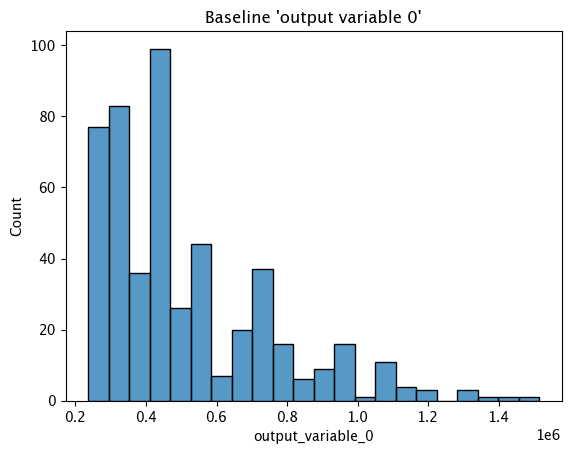

In [26]:
assay_builder_from_dates.baseline_histogram()

#### Baseline KDE Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_kde`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Kernel Density Estimation (KDE) chart of the assay baseline generated from the provided parameters.

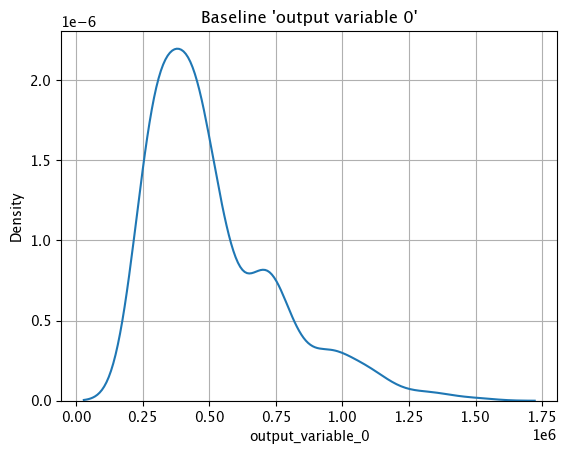

In [27]:
assay_builder_from_dates.baseline_kde()

#### Baseline ECDF Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_ecdf`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Empirical Cumulative Distribution Function (CDF) chart of the assay baseline generated from the provided parameters.

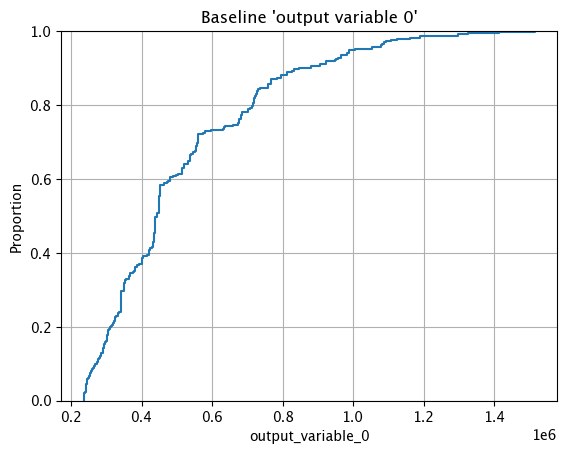

In [28]:
assay_builder_from_dates.baseline_ecdf()

### Assay Preview

Now that the baseline is defined, we look at different configuration options and view how the assay baseline and results changes.  Once we determine what gives us the best method of determining model drift, we can create the assay.

#### Analysis List Chart Scores

Analysis List scores show the assay scores for each assay result interval in one chart.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method [`wallaroo.assay.AssayAnalysisList.chart_scores(title: Optional[str] = None)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.chart_scores), with ability to display an optional title with the chart.

The following example shows retrieving the assay results and displaying the chart scores.  From our example, we have two windows - the first should be green, and the second is red showing that values were outside the alert threshold.

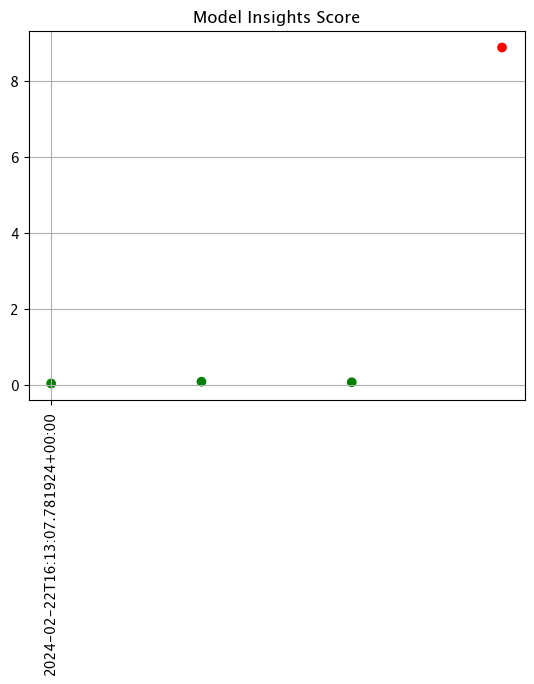

In [29]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()

#### Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a comparison between the baseline and an interval of inference data.

This is compared to the [Chart Scores](#analysis-list-chart-scores), which is a **list** of all of the inference data split into intervals, while the **Analysis Chart** shows the breakdown of one set of inference data against the baseline.

Score from the [Analysis List Chart Scores](#analysis-list-chart-scores) and each element from the [Analysis List DataFrame](#analysis-list-dataframe) generates 

The following fields are included.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

baseline mean = 513088.88569735526
window mean = 523401.741328125
baseline median = 444408.0
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.036723431597836184
scores = [0.0, 0.0054465677587239095, 0.00351406964764097, 0.0011239501647170409, 0.021833837078132627, 0.004805006948621639, 0.0]
index = None


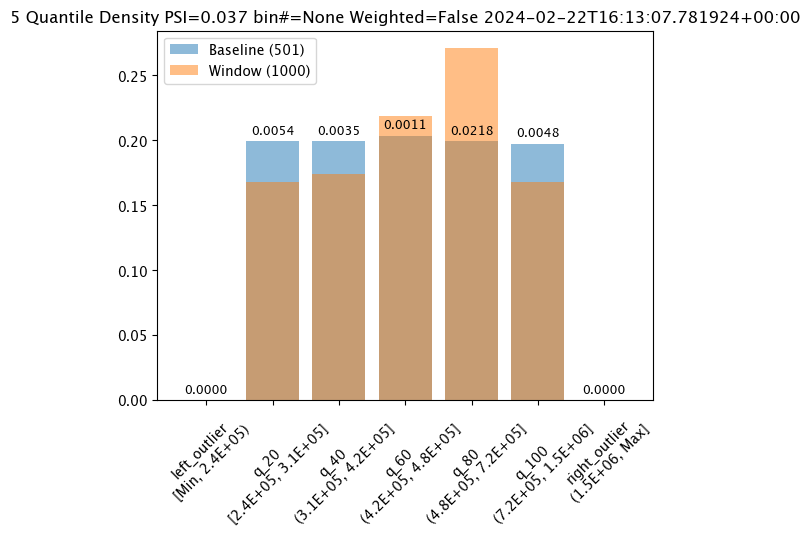

In [30]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

#### Analysis List DataFrame

`wallaroo.assay.AssayAnalysisList.to_dataframe()` returns a DataFrame showing the assay results for each window aka individual analysis.  This DataFrame contains the following fields:

| Field | Type | Description |
|---|---|---|
| **assay_id** | *Integer/None* | The assay id.  Only provided from uploaded and executed assays. |
| **name** | *String/None* | The name of the assay.  Only provided from uploaded and executed assays. |
| **iopath** | *String/None* | The iopath of the assay.  Only provided from uploaded and executed assays. |
| **score** | *Float* | The assay score. |
| **start** | *DateTime* | The DateTime start of the assay window.
| **min** | *Float* | The minimum value in the assay window.
| **max**  | *Float* | The maximum value in the assay window.
| **mean** | *Float* | The mean value in the assay window.
| **median** | *Float* | The median value in the assay window.
| **std** | *Float* | The standard deviation value in the assay window.
| **warning_threshold** | *Float/None* | The warning threshold of the assay window.
| **alert_threshold** | *Float/None* | The alert threshold of the assay window.
| **status** | *String* | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed.  

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`

In [31]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_dataframe()

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,,0.036723,2024-02-22T16:13:07.781924+00:00,2.362387e+05,1489624.250,5.234017e+05,4.486278e+05,230914.012105,None,0.25,Ok
1,None,,,0.082877,2024-02-22T16:15:07.781924+00:00,2.362387e+05,2016006.125,5.473354e+05,4.815304e+05,260871.745557,None,0.25,Ok
2,None,,,0.069016,2024-02-22T16:20:07.781924+00:00,2.362387e+05,2016006.000,5.394895e+05,4.510469e+05,264051.044244,None,0.25,Ok
3,None,,,8.868532,2024-02-22T16:21:07.781924+00:00,1.514079e+06,2016006.125,1.882197e+06,1.946438e+06,160686.049379,None,0.25,Alert


#### Configure Assays

Before creating the assay, **configure** the assay and continue to preview it until the best method for detecting drift is set.

##### Location Filter

This tutorial focuses on the assay configuration method `wallaroo.assay_config.WindowBuilder.add_location_filter` which takes the following parameters.

| Parameter | Type | Description |
|---|---|---|
| **locations** | List(String) | The list of model deployment locations for the assay. |

By default, the `locations` parameter includes **all locations** as part of the pipeline.  This is seen in the default where no location filter is set, and of the inference data is shown.

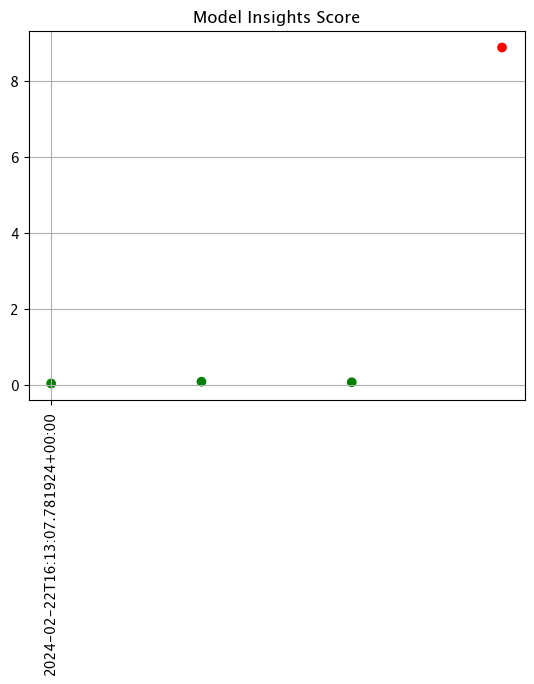

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,,0.036723,2024-02-22T16:13:07.781924+00:00,2.362387e+05,1489624.250,5.234017e+05,4.486278e+05,230914.012105,None,0.25,Ok
1,None,,,0.082877,2024-02-22T16:15:07.781924+00:00,2.362387e+05,2016006.125,5.473354e+05,4.815304e+05,260871.745557,None,0.25,Ok
2,None,,,0.069016,2024-02-22T16:20:07.781924+00:00,2.362387e+05,2016006.000,5.394895e+05,4.510469e+05,264051.044244,None,0.25,Ok
3,None,,,8.868532,2024-02-22T16:21:07.781924+00:00,1.514079e+06,2016006.125,1.882197e+06,1.946438e+06,160686.049379,None,0.25,Alert


In [35]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# set the width, interval, and time period
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
assay_results_from_dates.to_dataframe()

Now we will set the location to the ops center only pipeline and display the results.

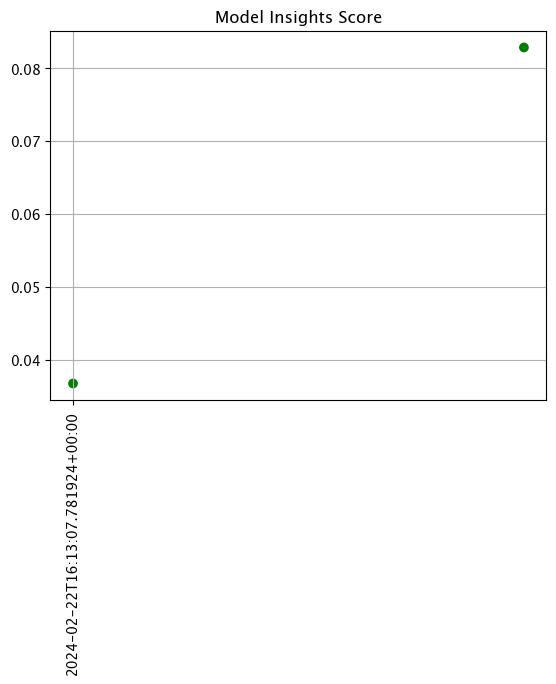

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,,0.036723,2024-02-22T16:13:07.781924+00:00,236238.671875,1489624.250,523401.741328,448627.812500,230914.012105,None,0.25,Ok
1,None,,,0.082877,2024-02-22T16:15:07.781924+00:00,236238.671875,2016006.125,547335.355203,481530.359375,260871.745557,None,0.25,Ok


In [36]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to the ops center
assay_builder_from_dates.window_builder().add_location_filter([ops_location])


# set the width, interval, and time period
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
assay_results_from_dates.to_dataframe()

Now we specify only our edge deployment location.

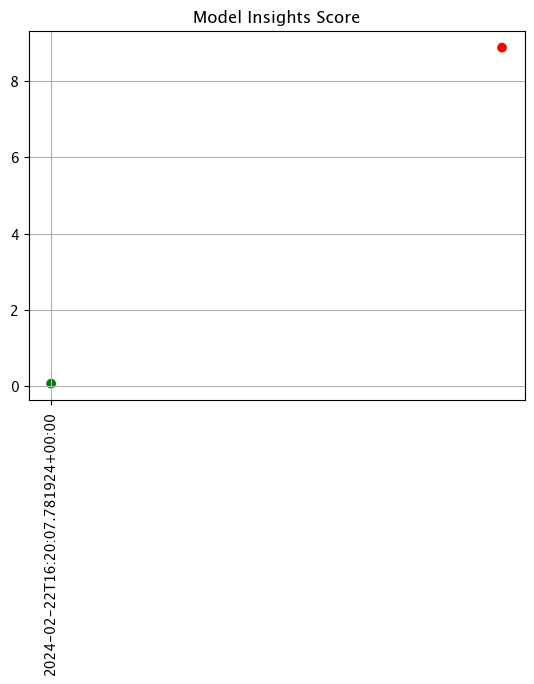

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,,0.069016,2024-02-22T16:20:07.781924+00:00,2.362387e+05,2016006.000,5.394895e+05,4.510469e+05,264051.044244,None,0.25,Ok
1,None,,,8.868532,2024-02-22T16:21:07.781924+00:00,1.514079e+06,2016006.125,1.882197e+06,1.946438e+06,160686.049379,None,0.25,Alert


In [37]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to the the edge location
assay_builder_from_dates.window_builder().add_location_filter([edge_name])


# set the width, interval, and time period
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
assay_results_from_dates.to_dataframe()

Now we specify both the Wallaroo Ops deployed pipeilne and the edge pipeline.

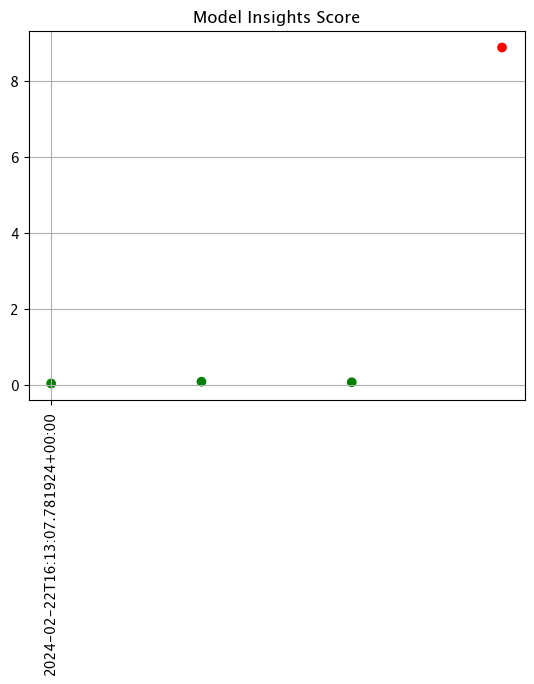

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,,0.036723,2024-02-22T16:13:07.781924+00:00,2.362387e+05,1489624.250,5.234017e+05,4.486278e+05,230914.012105,None,0.25,Ok
1,None,,,0.082877,2024-02-22T16:15:07.781924+00:00,2.362387e+05,2016006.125,5.473354e+05,4.815304e+05,260871.745557,None,0.25,Ok
2,None,,,0.069016,2024-02-22T16:20:07.781924+00:00,2.362387e+05,2016006.000,5.394895e+05,4.510469e+05,264051.044244,None,0.25,Ok
3,None,,,8.868532,2024-02-22T16:21:07.781924+00:00,1.514079e+06,2016006.125,1.882197e+06,1.946438e+06,160686.049379,None,0.25,Alert


In [38]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to both the edge location and ops pipeline
assay_builder_from_dates.window_builder().add_location_filter([ops_location, edge_name])


# set the width, interval, and time period
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
assay_results_from_dates.to_dataframe()

### Create Assay

With the assay previewed and configuration options determined, we officially create it by uploading it to the Wallaroo instance.

Once it is uploaded, the assay runs an analysis based on the window width, interval, and the other settings configured.

Assays are uploaded with the `wallaroo.assay_config.upload()` method. This uploads the assay into the Wallaroo database with the configurations applied and returns the assay id. Note that assay names **must be unique across the Wallaroo instance**; attempting to upload an assay with the same name as an existing one will return an error.

`wallaroo.assay_config.upload()` returns the assay id for the assay.

Typically we would just call `wallaroo.assay_config.upload()` after configuring the assay.  For the example below, we will perform the complete configuration in one window to show all of the configuration steps at once before creating the assay, and narrow the locations to only the Wallaroo Ops deployed pipeline and the single edge.

In [39]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to both the edge location and ops pipeline
assay_builder_from_dates.window_builder().add_location_filter([ops_location, edge_name])


# set the width, interval, and time period
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)


assay_id = assay_builder_from_dates.upload()

# wait 65 seconds for the first analysis run performed
time.sleep(65)


The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.  The following is an example of another assay in the Wallaroo Dashboard.

![Sample assay in the UI](images/housepricesaga-sample-assay.png)

### Get Assay Results

Once an assay is created the assay runs an analysis based on the window width, interval, and the other settings configured.

Assay results are retrieved with the `wallaroo.client.get_assay_results` method, which takes the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_id** | *Integer* (*Required*) | The numerical id of the assay. |
| **start** | *Datetime.Datetime* (*Required*) | The start date and time of historical data from the pipeline to start analyses from. |
| **end** | *Datetime.Datetime* (*Required*) | The end date and time of historical data from the pipeline to limit analyses to. |

* **IMPORTANT NOTE**:  This process requires that additional historical data is generated from the time the assay is created to when the results are available. To add additional inference data, use the [Assay Test Data](#assay-test-data) section above.

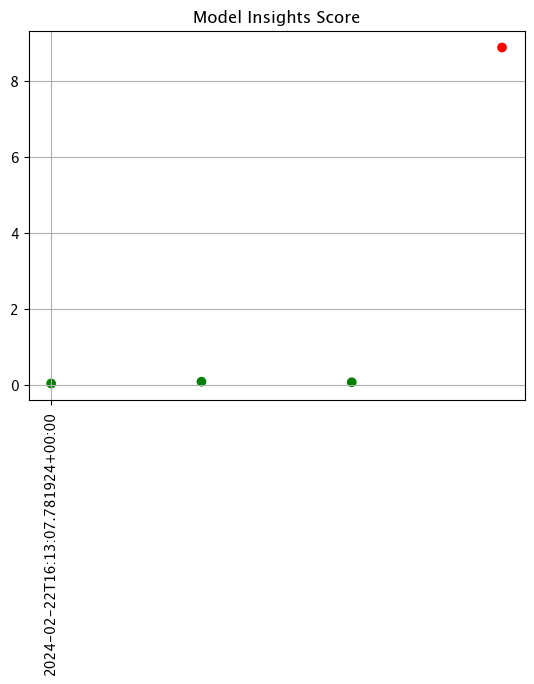

In [40]:
assay_results = wl.get_assay_results(assay_id=assay_id,
                     start=assay_window_start,
                     end=datetime.datetime.now())

assay_results.chart_scores()

baseline mean = 513088.88569735526
window mean = 523401.741328125
baseline median = 444408.0
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.03672343
scores = [0.0, 0.0054465677587239095, 0.00351406964764097, 0.0011239501647170409, 0.021833837078132627, 0.004805006948621639, 0.0]
index = None


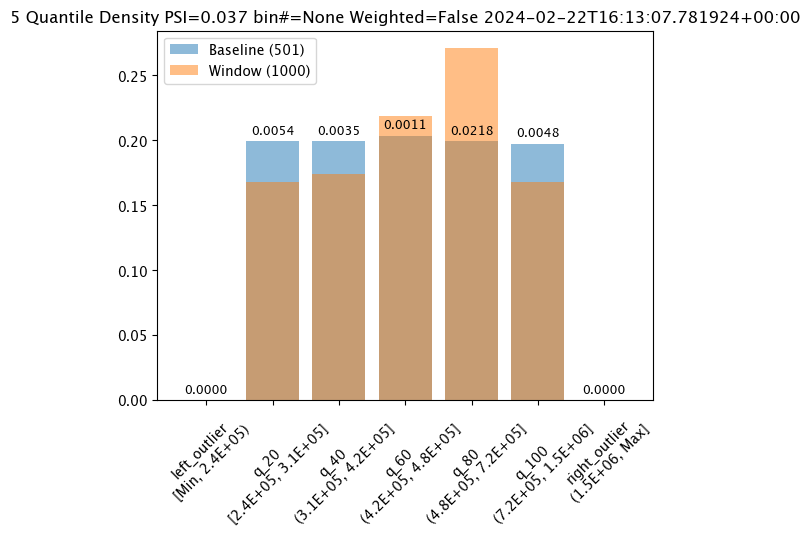

In [41]:
assay_results[0].chart()

### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [42]:
mainpipeline.undeploy()

name,assay-demo-tutorial
created,2024-02-22 16:10:47.470433+00:00
last_updated,2024-02-22 16:16:30.051729+00:00
deployed,False
arch,None
accel,None
tags,
versions,"d7c8dbf6-dd09-4420-af0b-aecee2765b9a, dffc6643-7621-4f75-bd5b-0e9844ee17da, 59f472d8-a7ec-4a79-bd3a-f568254b6d62"
steps,house-price-estimator
published,False
